In [1]:
#Importing libraries
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import scipy
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from numba import jit
import copy
from scipy.stats import norm

In [44]:
a = np.array([np.random.normal() for i in range(100000)])
print(np.var(a))

1.0034901309326196


In [161]:
#Values
r = 12e-9
eta = 1e-3
gamma = 6*np.pi*eta*r
gamma2 = 3*gamma
L = 20e-6
alpha = 0.2
kbT = 26e-3*1.602e-19

#tau = 2
DeltaU = 80*1.602e-19
#DeltaU = 0.1*kbT*10

omega = DeltaU/(gamma*L**2)
omega2 = omega/3
D = kbT/DeltaU

#Flashing function
@jit(nopython=True)
def f(t, tau):
    #global tau
    return int(t%tau >= 0.75*tau) #np.heaviside(t%tau - 0.75*tau, 1)

#Ratchet potential
@jit(nopython=True)
def Ur(x):
    global alpha, L, DeltaU
    #return np.heaviside(alpha*L - x%L, 1)*x%L/(alpha*L)*DeltaU + np.heaviside(x%L - alpha*L, 1)*(L-x%L)/(L*(1-alpha))*DeltaU
    return int(x%L < alpha*L)*x%L/(alpha*L)*DeltaU + int(x%L >= alpha*L)*(L-x%L)/(L*(1-alpha))*DeltaU

#Flashin ratchet potential
def U(x, t, tau):
    return Ur(x)*f(t, tau)

#-dU/dx analytically
@jit(nopython=True)
def Fx(x):
    global alpha, L, DeltaU
    #return np.heaviside(alpha - x%1, 1)*-1/(alpha*L)*DeltaU + np.heaviside(x%1 - alpha, 1)/(L*(1-alpha))*DeltaU
    #return on*np.heaviside(alpha*L - x%L, 1)*-1/(alpha*L) + on*np.heaviside(x%L - alpha*L, 1)/(L*(1-alpha))
    return int(x%L < alpha*L)*-1/(alpha*L) + int(x%L >= alpha*L)/(L*(1-alpha))

#I don't think I used this one
@jit(nopython=True)
def Ft(t):
    global omega
    return f(t/omega)

#Force, or -dU/dx
@jit(nopython=True)
def F(x, t, tau):
    return DeltaU*Fx(x)*f(t, tau)

#max dU/dx
def maxF():
    global DeltaU
    x = np.linspace(0, 2*L, 1000)
    test = 0
    for i in range(1000):
        if np.abs(Fx(x[i])) > test:
            test = np.abs(Fx(x[i]))
    return DeltaU*test

#Criterion for dt being small enough
def criterion(dt):
    global gamma, kbT, alpha, omega
    return 1/gamma*maxF()*dt + 4*np.sqrt((2*kbT*dt)/gamma) < 0.1*L*alpha
    
#Euler scheme reduced units one iteration
@jit(nopython=True)
def ForwardEuler(x, t, dt, tau):
    global D, L, omega
    xn = x + F(x*L, t/omega, tau)*L*dt/DeltaU + np.sqrt(2*D*dt)*np.random.normal()
#     xn = x + F(x, t)*dt/DeltaU + 2*np.sqrt(2*D*dt)*np.random.normal()
    tn = t + dt
    return xn, tn

#Euler scheme normal units one iteration
@jit(nopython=True)
def ForwardEuler2(x, t, dt, tau):
    global gamma, kbT
    xn = x + 1/gamma*F(x, t, tau)*dt + np.sqrt(2*kbT*dt/gamma)*np.random.normal()
#     xn = x + F(x, t)*dt/DeltaU + 2*np.sqrt(2*D*dt)*np.random.normal()
    tn = t + dt
    return xn, tn

#Multi iteration Euler scheme reduced units
@jit(nopython=True)
def ParticleMotion(x0, t0, dt, tau, tEnd, Res):
    Length = int((tEnd - t0)/dt/Res)+1
#     if not criterion(dt):
#         print("dt not sufficiently small, choose a lower dt.")
#         return 0, 0
    c = 1
    t = t0
    x = x0
    T = np.zeros(Length)
    X = np.zeros(Length)
    while t <= tEnd:
        x, t = ForwardEuler(x, t, dt, tau)
        c += 1
        if c%Res == 0:
            X[c//Res], T[c//Res] = x, t
    return X, T

#Multi iteration Euler scheme normal units
@jit(nopython=True)
def ParticleMotion2(x0, t0, dt, tau, tEnd, Res):
    Length = int((tEnd - t0)/dt/Res)+1
#     if not criterion(dt):
#         print("dt not sufficiently small, choose a lower dt.")
#         return 0, 0
    c = 1
    t = t0
    x = x0
    T = np.zeros(Length)
    X = np.zeros(Length)
    while t <= tEnd:
        x, t = ForwardEuler2(x, t, dt, tau)
        c += 1
        if c%Res == 0:
            X[c//Res], T[c//Res] = x, t
    return X, T

#Maps positions as energy, requires potential on at all times. Needs simulated trajectory, x, as input. V is list of zeros
@jit(nopython=True)
def Vlist(V, x, dV, R):
    for i in range(len(x)):
        V[int(np.rint(Ur(x[i])//(R*dV)))] += 1
    return V

#Finds average velocity from tau list, reduced units
def VofTau(x0, t0, dt, tau, tEnd, Res):
    global L, omega
    v = np.zeros(len(tau))
    for i in range(len(tau)):
        print(i)
        X, T = ParticleMotion(x0, t0*omega, dt*omega, tau[i], tEnd*omega, Res)
        v[i] = (X[-1]-X[0])/(T[-1]-T[0])
    return v*L*omega

#Multi iteration Euler scheme reduced units for N particles of each size, reduced units
def MultiParticleMotion(x0, t0, dt, tau, tEnd, Res, N):
    global omega, omega2
    L1 = int((tEnd*omega - t0*omega)/(dt*omega*Res))+1
    L2 = int((tEnd*omega2 - t0*omega2)/(dt*omega2*Res))+1
    X1 = np.zeros([N, L1])
    T1 = np.zeros([N, L1])
    X2 = np.zeros([N, L2])
    T2 = np.zeros([N, L2])
    for i in range(N):
        if i%100000 == 0:
            print(i)
        X1[i], T1[i] = ParticleMotion(x0, t0*omega, dt*omega, tau, tEnd*omega, Res)
        X2[i], T2[i] = ParticleMotion(x0, t0*omega2, dt*omega2, tau, tEnd*omega2, Res)
    return X1, T1, X2, T2


#Returns distribution of Browninan motion after time tEnd, requires potential off at all times
def DensityOfBrownian(N, x0, t0, dt, tau, tEnd, Res, Res2):
    global kbT, gamma, gamma2
    X1, T1, X2, T2 = MultiParticleMotion(x0, t0, dt, tau, tEnd, Res, N)
    Xmin = np.min([np.amin(X1), np.amin(X2)])
    Xmax = np.max([np.amax(X1), np.amax(X2)])
    Lim = 1.5*np.max(np.abs([Xmin, Xmax]))
    xlist = np.linspace(-1*Lim*L, Lim*L, Res2)
    dX = xlist[1] - xlist[0]
    X1list = np.zeros(Res2)
    X2list = np.zeros(Res2)
    for i in range(N):
        X1list[int(rint((X1[i][-1]+Lim)*L/dX))] += 1
        X2list[int(rint((X2[i][-1]+Lim)*L/dX))] += 1
    Diff1 = kbT/gamma
    Diff2 = kbT/gamma2
    Analyt1 = N/np.sqrt(4*np.pi*Diff1*tEnd)*np.exp(-xlist**2/(4*Diff1*tEnd))
    Analyt2 = N/np.sqrt(4*np.pi*Diff2*tEnd)*np.exp(-xlist**2/(4*Diff2*tEnd))
    return xlist, Analyt1, Analyt2, X1list/dX, X2list/dX

#Creates density distributions from positions after time tEnd
def DensityOfParticles(X1f, T1f, X2f, T2f, tEnd, tau, Nx, N, lim):
    global L
    xlist = np.linspace(-2*L, tEnd/tau*L*lim, Nx)
    print(len(xlist))
    dX = xlist[1] - xlist[0]
    X1list = np.zeros(Nx)
    X2list = np.zeros(Nx)
    for i in range(N):
        X1list[int(rint((X1f[i][-1]+2)*L/dX))] += 1
        X2list[int(rint((X2f[i][-1]+2)*L/dX))] += 1
    return xlist, X1list/dX, X2list/dX

#Determines theoretical average velocity based on tau and shift. Shift is determined by dt
def theoreticalV(alpha, kbT, gamma, beta, tau, L, shift):
    diff = kbT/gamma
    return (norm.sf(alpha, shift, np.sqrt(2*diff*beta*tau)/L)-norm.cdf(alpha-1, shift, np.sqrt(2*diff*beta*tau)/L))*L/tau

#Simulates trajectory with only one iteration per cycle. 
def test(beta, tau, N, chi):
    global L, gamma, kbT, alpha
    x = np.zeros(N+1)
    t = np.zeros(N+1)
    for i in range(N):
        t[i+1] = (i+1)*tau
        x1 = np.sqrt(2*kbT*beta*tau/(gamma*chi))*np.random.normal()/L
        x[i+1] = x[i] + ((x1-alpha)//1 +1)*L
    return x, t

In [ ]:
criterion(2e-5)

In [4]:
X1, T1, X2, T2 = MultiParticleMotion(0, 0, 2e-5, 0.4, 80, 10000, 20000)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [12]:
x, X1t, X2t = DensityOfParticles(X1, T1, X2, T2, 80, 0.4, 2001, 20000, 0.21)

2001


<IPython.core.display.Javascript object>


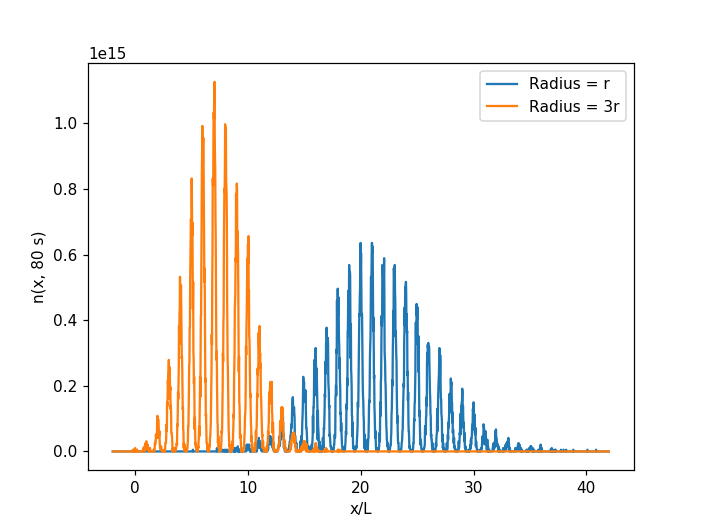

In [16]:
%matplotlib notebook
plt.figure()
dX = x[1]-x[0]
plt.plot(x/L, X1t/dX, label = "Radius = r")
plt.plot(x/L, X2t/dX, label = "Radius = 3r")
#plt.title("Position distribution after 200 cycles")
plt.xlabel("x/L")
plt.ylabel("n(x, 80 s)")
plt.legend()

1.0
1.0


<IPython.core.display.Javascript object>


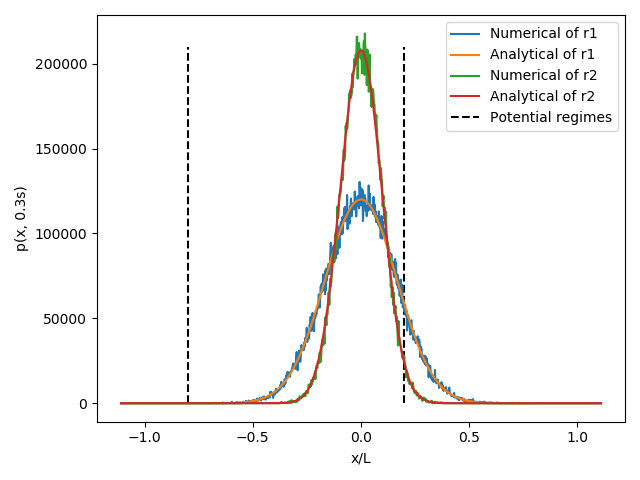

In [109]:
#x, An1, An2, X1, X2 = DensityOfBrownian(10000, 0, 0, 2e-5, 10, 0.1, 10)
#print(np.sum(X1)*(x[1]-x[0]))
print((np.sum(X1[117:]) + 0.5*X1[116])*(x[1]-x[0])/1e5)
print((np.sum(X2[117:]) + 0.5*X2[116])*(x[1]-x[0])/1e5)
plt.plot(x/L, X1/1e5, label = "Numerical of r1")
plt.plot(x/L, An1/1e5, label = "Analytical of r1")
plt.plot(x/L, X2/1e5, label = "Numerical of r2")
plt.plot(x/L, An2/1e5, label = "Analytical of r2")
plt.vlines(np.array([-0.8, 0.2]), 0, 210000, colors='k', linestyles='dashed', label = "Potential regimes")
#plt.title("Particle distribution of Brownian motion at t = 0.1 s")
plt.xlabel("x/L")
plt.ylabel("p(x, 0.3s)")
plt.legend()
plt.tight_layout()

In [192]:
X1sf, T1sf, X2sf, T2sf =  MultiParticleMotion(0, 0, 2e-5, 0.4, 0.3, rest, 1000000)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000


In [108]:
x, An1, An2, X1, X2 = DensityOfBrownian(100000, 0, 0, 2e-5, 10, 0.3, 10, 1001)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, 'Average drift velocity')

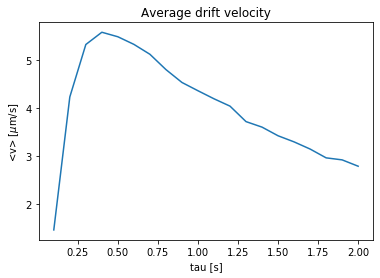

In [3]:
tau = np.linspace(0.1, 2.0, 20)
v = VofTau(0, 0, 1e-5, tau, 20000, 2000000)
plt.plot(tau, v*1e6)
plt.xlabel("tau [s]")
plt.ylabel(r'<v> [$\mu$m/s]')
plt.title("Average drift velocity")

In [53]:
print(v[3]*1e6, v[13]*1e6)

5.647289173247873 3.6131759193463613


0.4 5.577579942319798


<IPython.core.display.Javascript object>


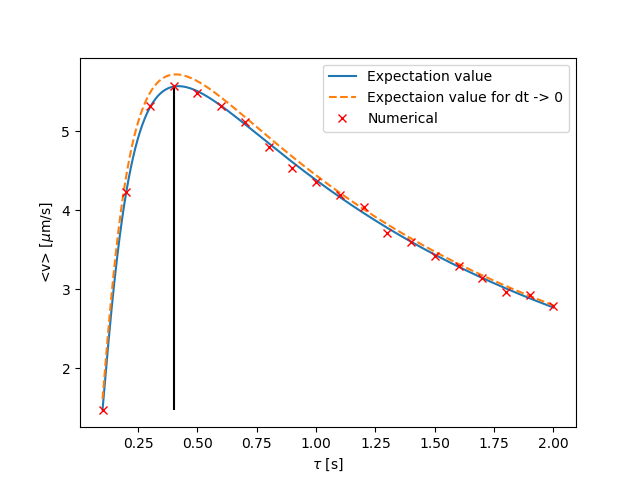

In [241]:
%matplotlib notebook
print(tau[3], v[3]*1e6)
plt.figure()
plt.plot(taut, vt*1e6, label = "Expectation value")
plt.vlines(0.4, v[0]*1e6,  v[3]*1e6)
plt.plot(taut, vt1*1e6, label = "Expectaion value for dt -> 0", linestyle = '--')
plt.plot(tau, v*1e6, 'rx', label = "Numerical") #, s=4)
plt.xlabel(r'$\tau$ [s]')
plt.ylabel(r'<v> [$\mu$m/s]')
#plt.title("Average drift velocity")
plt.legend()

In [116]:
taut = np.linspace(0.1, 2, 1000)
vt = np.zeros(1000)
for i in range(1000):
    vt[i] = theoreticalV(0.2, kbT, gamma, 0.75, taut[i], L, 0) #-shift*0.5*0.75)

In [249]:
v = VofTau(0, 0, 1e-5, tau, 2000, 200000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


<IPython.core.display.Javascript object>


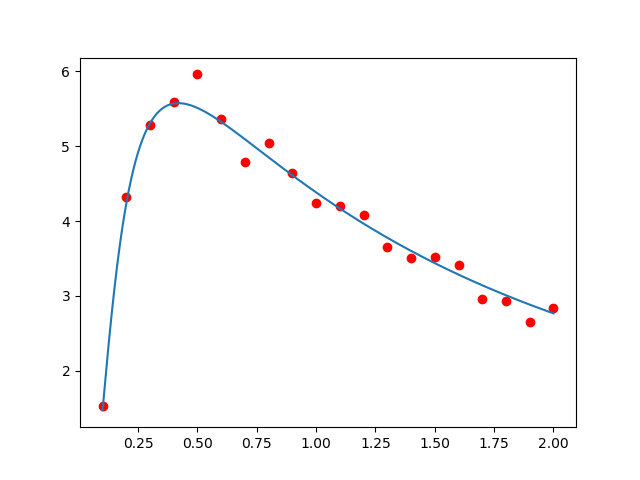

In [250]:
plt.plot(tau, v*1e6, 'ro')
plt.plot(taut, vt*1e6)

Text(0, 0.5, '<v> [$\\mu$m/s]')

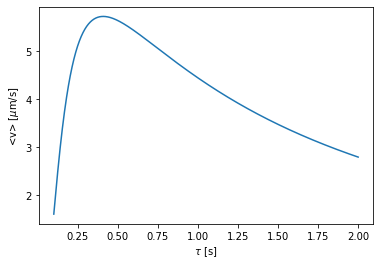

In [118]:
plt.plot(taut, vt*1e6)
plt.xlabel(r'$\tau$ [s]')
plt.ylabel(r'<v> [$\mu$m/s]')

In [121]:
a = np.amax(vt)
b = np.where(vt == a)
taut[b[0]]

array([0.40810811])

In [151]:
N = 100
dT = np.logspace(-9, -3, N)
dx0 = np.zeros(N)
for i in range(N): #1e8
    print(i)
    x, t = ParticleMotion2(0,  0, dT[i], 0.4, 1e9*dT[i], 1000)
    shift = maxF()/gamma*dT[i]/L*-0.5*0.75
    dx0[i] = np.abs((np.mean(x/L)-shift)/(np.mean(x/L)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [154]:
kvotient = np.sqrt(2*kbT/gamma*dT)/(1/gamma*maxF()*dT)

<IPython.core.display.Javascript object>


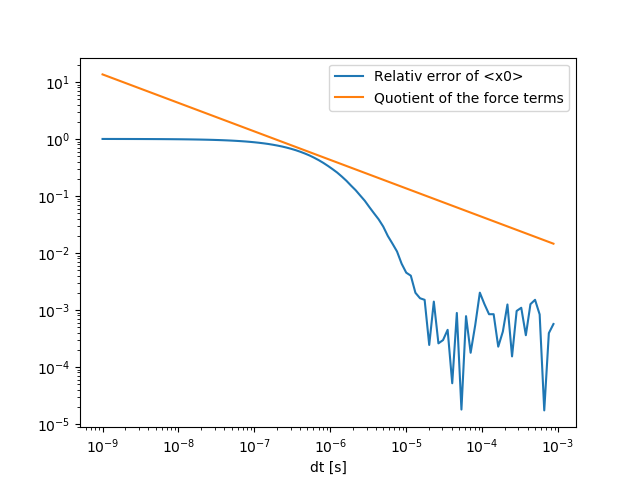

In [158]:
plt.loglog(dT[:-1], dx0[:-1], label = "Relativ error of <x0>")
plt.loglog(dT[:-1], kvotient[:-1], label = "Quotient of the force terms")
plt.xlabel("dt [s]")
plt.legend()
#print(dT)

In [58]:
x, t = ParticleMotion2(0,  0, 1e-5, 0.4, 80, 1000)

In [95]:
x1, t1 = test(0.75, 0.4, 200)

In [118]:
x4, t4 = test(0.75, 0.4, 200, 3)

In [91]:
x2, t2 = ParticleMotion(0, 0, 1e-5*omega, 0.4, 80*omega, 1000)

In [114]:
x3, t3 = ParticleMotion(0, 0, 1e-5*omega2, 0.4, 80*omega2, 1000)

<IPython.core.display.Javascript object>


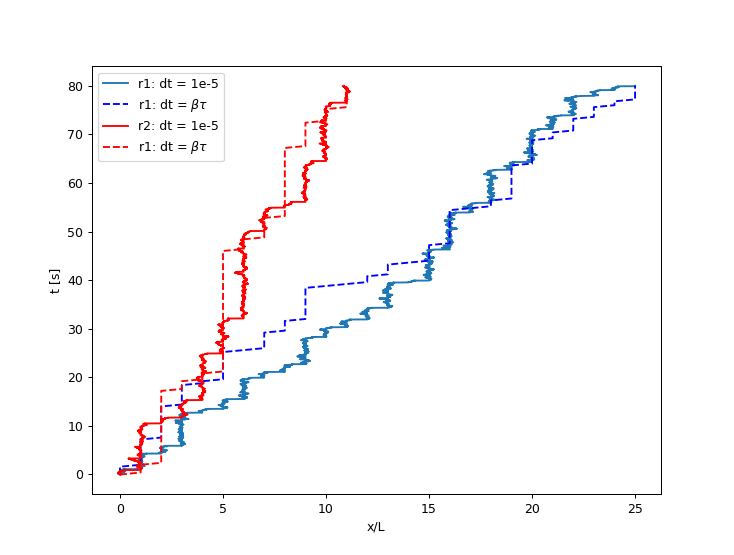

Text(0, 0.5, 't [s]')

In [120]:
plt.plot(x2, t2/omega, label = 'r1: dt = 1e-5')
plt.plot(x1/L, t1, 'b--', label = r'r1: dt = $\beta \tau$')
plt.plot(x3, t3/omega2, 'r-',label = 'r2: dt = 1e-5')
plt.plot(x4/L, t4, 'r--', label = r'r1: dt = $\beta \tau$')
#plt.plot(x2, t2/omega)
plt.legend()
plt.xlabel("x/L")
plt.ylabel("t [s]")

In [39]:
shift = maxF()/gamma*6e-8/L
shift*= -0.5*0.75
shift

-1.5935388677076017e-05

416
6.095203570548874e-20 5.0166351942292165e-20 6.095203570548874e-20
DU = 833334
275 275
P = 0.2847151467604873


<IPython.core.display.Javascript object>


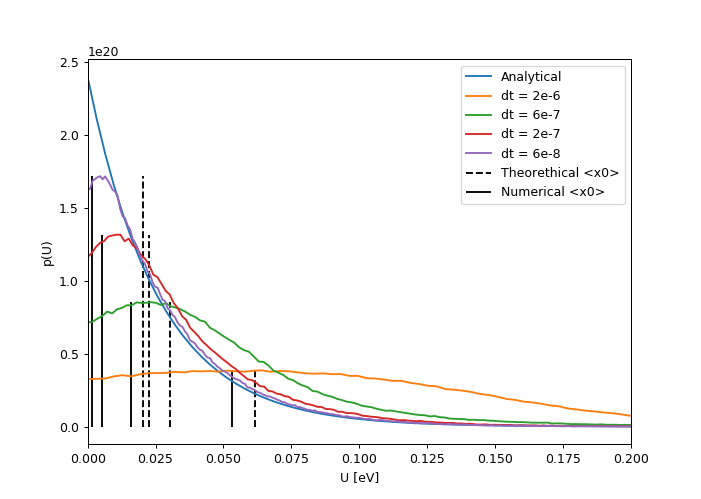

(0, 0.2)

In [43]:
y = x/L
a1, a2 = np.amin(y), np.amax(y)
R3 = 2000 #
Nr = int(len(x)/R)
print(Nr)
dN = (a2-a1)/len(y)
P = np.zeros(Nr)
V3 = np.zeros(int(Nr*1.1)) #
#Ulist = Ur(y)
b1, b2 = Ur(a1*L), Ur(a2*L)
b3 = max(b1, b2)
dV = b3/len(x)
print(b1, b2, b3)
Px = np.linspace(a1, a2, Nr)
Vx3 = np.linspace(0, 1.1*b3, int(Nr*1.1)) #


Van = np.exp(-Vx/kbT)/(kbT*(1-np.exp(-DeltaU/kbT)))

%matplotlib notebook
V3 = Vlist(V3,  x, dV, R3) ###
print("DU =", len(x))
print(len(Van), len(Vx))
dx3 = Vx3[1] - Vx3[0]  ###
V3 *= 1/np.sum(V3*dx3)*R3 ####
print("P =", np.sum(V*(dV)))

#plt.plot(Px, P/len(y))
plt.plot(Vxa[:20000]/1.6e-19, Van[:20000], label = "Analytical")
plt.plot(Vx[:20000]/1.6e-19, V[:20000]/R, label = "dt = 2e-6")
plt.plot(Vx2[:20000]/1.6e-19, V2[:20000]/R2, label = "dt = 6e-7")
plt.plot(Vx1[:20000]/1.6e-19, V1[:20000]/R1, label = "dt = 2e-7")
plt.plot(Vx3[:20000]/1.6e-19, V3[:20000]/R3, label = "dt = 6e-8")
#plt.hlines(1e20, 0, D1)
plt.vlines(U1[0], 0, np.amax(V/R), label = "Theorethical <x0>", linestyles = 'dashed')
plt.vlines(U2[0], 0, np.amax(V1/R1), linestyles = 'dashed')
plt.vlines(U3[0], 0, np.amax(V2/R2), linestyles = 'dashed')
plt.vlines(U4[0], 0, np.amax(V3/R3), linestyles = 'dashed')

plt.vlines(U1[1], 0, np.amax(V/R), label = "Numerical <x0>")
plt.vlines(U2[1], 0, np.amax(V1/R1))
plt.vlines(U3[1], 0, np.amax(V2/R2))
plt.vlines(U4[1], 0, np.amax(V3/R3))
plt.xlabel("U [eV]")
plt.ylabel("p(U)")
plt.legend()
#plt.plot(b3, 0, "ro")
plt.xlim(0, 0.2)




In [160]:
#The rest is for solving the last integral in report

In [76]:
def integrand(x, x0, tau, D, beta):
    return ((x-x0)**2/(4*D*tau*beta) - 3/2)*np.exp(-(x-x0)**2/(4*D*beta*tau))    

In [65]:
quad(integrand, 0.2, np.inf, args=(0, D, beta, 0.1))

(2.3678617574364417e-182, 4.681415842989661e-182)

In [139]:
N = 10000
tau = np.linspace(0.39, 0.42, N)
I = np.zeros(N)
for i in range(N):
    I[i] = quad(integrand, alphax, np.inf, args=(0, tau[i]*omega, Datt, beta))[0]